# imagine-decoding-challenge

Example notebook how you can load and interact with the data of the `imagine-deocing-challenge`.

In this sample notebook we will 
1. Load the data
2. Perform cross-validation on the localizer data
3. Create a decoder per item per subject
4. Try to predict the class labels of the imagine trials


### Preparation

Import all libraries necessary for this tutorial. 
You can run this command to install them: 

   `pip install numpy pandas scipy mne scikit-learn tqdm ipywidgets`
   
Additionally, download the challenge data from XXX and place in a directory


In [38]:
import os
# just for convenience of this example, ignore the non-convergent warnings
os.environ['PYTHONWARNINGS']="ignore"
from pathlib import Path
import numpy as np
import pandas as pd
import sklearn
import scipy
import mne
from tqdm import tqdm


np.random.seed(0)  # for reproducibility

data_dir = Path('w:/group_klips/data/data/Simon/DeSMRRest/imagine_challenge//')  # set to path where your data is
data_train = data_dir / 'train'
data_test = data_dir / 'test'

assert data_dir.is_dir(), f'does not exist: {data_dir=}'

### 1. load the data

List all participants of train and test dir.

In [40]:
localizer_train = {}
localizer_test = {}

imagine_train = {}
imagine_test = {}

tqdm_loop = tqdm(total=58)

# load train set
tqdm_loop.set_description('loading localizer train data')
for file in data_train.rglob("*localizer-epo.fif"):
    subject = file.parents[0].name
    epochs_subj = mne.read_epochs(file, preload=True, verbose='WARNING')
    localizer_train[subject] = epochs_subj
    tqdm_loop.update()

# load test set
tqdm_loop.set_description('loading localizer test data')
for file in data_test.rglob("*localizer-epo.fif"):
    subject = file.parents[0].name
    epochs_subj = mne.read_epochs(file, preload=True, verbose='WARNING')
    localizer_test[subject] = epochs_subj
    tqdm_loop.update()

# load train set
tqdm_loop.set_description('loading imagine train data')
for file in data_train.rglob("*imagine-epo.fif"):
    subject = file.parents[0].name
    epochs_subj = mne.read_epochs(file, preload=True, verbose='WARNING')
    imagine_train[subject] = epochs_subj
    tqdm_loop.update()

# load test set
tqdm_loop.set_description('loading imagine test data')
for file in data_test.rglob("*imagine-epo.fif"):
    subject = file.parents[0].name
    epochs_subj = mne.read_epochs(file, preload=True, verbose='WARNING')
    imagine_test[subject] = epochs_subj
    tqdm_loop.update()

assert len(localizer_train)==15, f'participant missing, {len(localizer_train)=} =! 15'
assert len(localizer_test)==14, f'participant missing, {len(localizer_test)=} =! 14'
assert len(imagine_train)==15, f'participant missing, {len(imagine_train)=} =! 15'
assert len(imagine_test)==14, f'participant missing, {len(imagine_test)=} =! 14'


loading imagine test data: 100%|███████████████████████████████████████████████████████| 58/58 [01:14<00:00,  1.29s/it]

loading imagine test data: 100%|███████████████████████████████████████████████████████| 58/58 [00:46<00:00,  1.72it/s]

## 2. Perform cross validation on the localizer

We train a very simple time-by-time decoder and cross-validate with 5 folds.

Under the hood, a classifier will be fit for each time point and tested on hold-out data of the same time point of the same participant, i.e., each time point is treated independently. This is a standard approach in memory (human replay) research.

All of this will take quite a long time, so go get a cup of coffee while it's running.

In [ ]:
from mne.decoding import cross_val_multiscore, SlidingEstimator 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

# make pipeline that scales our very small Tesla values to something numerically stable
clf = make_pipeline(RobustScaler(), LogisticRegression(C=10, penalty='l1', solver="liblinear", max_iter=1000))
decoder = SlidingEstimator(clf, scoring="accuracy", n_jobs=5, verbose=True)

# collect accuracies in this
df_acc = pd.DataFrame()

# progess bar across both sets
tqdm_loop = tqdm(total=len(localizer_train) + len(localizer_test), desc='cross-validating')

for localizer_data, set_name in zip([localizer_train, localizer_test], ['train', 'test']):
    for subj, epochs in localizer_data.items():
        train_x = epochs.get_data()
        train_y = epochs.events[:, 2]

        # do a five fold cross-validation
        scores = cross_val_multiscore(decoder, train_x, train_y, cv=5, verbose='WARNING', n_jobs=5)
    
        # Mean scores across cross-validation splits
        scores = np.mean(scores, axis=0)

        # save in dataframe
        df_subj = pd.DataFrame({'accuracy': scores,
                                'timepoint': np.arange(-200, 1010, 10),
                                'subject': subj,
                                'set': set_name})
        df_acc = pd.concat([df_acc, df_subj])
        tqdm_loop.update()
        
# Plot results
fig, ax = plt.subplots()
sns.lineplot(df_acc, x='timepoint', y='accuracy', hue='set', ax=ax)
ax.axhline(0.1, color="k", linestyle="--", label="chance")
ax.axvline(0.0, color="k", linestyle="-", label='stim onset')
ax.legend()
ax.set_title("Decoding of localizer")


>30% decoding accuracy, pretty good!

## 3. Train a final decoder per participant

Given the previous decoding accuracy plot, we will train a decoder on the mean values of the visual peak, which was around 200ms. 

This is a standard approach in many decoding studies, however, the visual peak might not generalize to representations that are being active during mental imagery. Theefo

In [43]:
warnings.simplefilter('ignore', FutureWarning)

clf = make_pipeline(RobustScaler(), LogisticRegression(C=10, penalty='l1', solver="liblinear", max_iter=1000))

decoders = {}  # save decoder per participant

tqdm_loop = tqdm(total=len(localizer_train)+len(localizer_test), desc='training decoder')
for localizer_data, set_name in zip([localizer_train, localizer_test], ['train', 'test']):
        for subj, epochs in localizer_data.items():
            train_x = epochs.get_data()
            train_y = epochs.events[:, 2]
            # train classifier on mean values
            t = 40  # 200ms after stimulus onset is 400ms after epoch onset, as tmin=-0.2
            train_x_mean = train_x[:, :, t]
            clf.fit(train_x_mean, train_y)
            decoders[subj] = clf
            tqdm_loop.update()

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:48<00:00,  3.00s/it]

## 4. Evaluation on train set and then give a prediction for the test set

We're going to run a very simplistic way to try and guess the class labels: Get probabilities per timestep, normalize them and then take the sum of probabilities to determine a winner per class

In [90]:
accuracies = []
for subj, epochs in tqdm(imagine_train.items(), desc='predicting'):
    # get previously trained decoder
    clf = decoders[subj]

    # get epochs from the imagine trials
    test_x = epochs.get_data()
    test_y = epochs.events[:, 2]

    # predict imagine trials across the time axis
    # simple approach: just take the maximum AUC per class within the first 1000 ms
    probas = np.array([clf.predict_proba(test_x[:, :, t]) for t in range(120)])

    # normalize probabilities across all classes
    probas = probas / probas.mean(0).mean(0)

    # simple approach: just take the maximum AUC per class within the first 1000 ms
    mean_probas = np.mean(probas, axis=0)  # 0 is time axis
    winner_class = np.argmax(mean_probas, axis=-1) + 1  # ofset by one as our class labels start at 1
        
    accuracy = np.mean(winner_class==test_y)
    accuracies += [accuracy]

stat = scipy.stats.ttest_1samp(accuracies, 0.1, alternative='greater')

print(f'mean accuracy of our prediction of imagine trials was {np.mean(accuracies)=:.02f}, that has a {stat.pvalue=:.02f}')



predicting: 100%|██████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 14.64it/s]

mean accuracy of our prediction of imagine trials was np.mean(accuracies)=0.11, that has a stat.pvalue=0.25


## 4.1 plot one sample participant

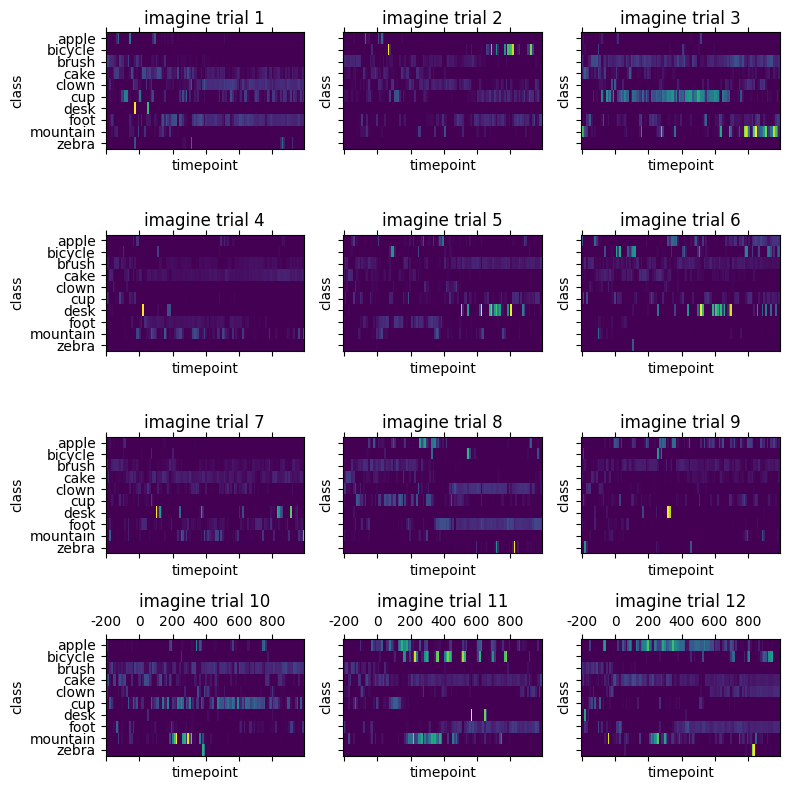

In [91]:
fig, axs = plt.subplots(4, 3, sharex=True, sharey=True, figsize=[8, 8])

labels = ['apple', 'bicycle', 'brush', 'cake', 'clown', 'cup', 'desk', 'foot', 'mountain', 'zebra']
for i, ax in enumerate(axs.flat):
    proba_i = probas[:, i, :]
    ax.matshow(proba_i.T, aspect='auto')
    ax.set(xlabel='timepoint', ylabel='class', title=f'imagine trial {i+1}')
    ax.set_yticks(np.arange(10), labels)
    ax.set_xticks(np.arange(0, 120, 20), np.arange(-200, 1000, 200))

fig.tight_layout()


## 5. Create final predictions for Kaggle

We got 11 % accuracy on the test set, that is only insignificantly above chance level! 

Well, bummer, isn't it? But maybe you can find a better approach!

Nevertheless, for completeness, let's create a prediction for the test set to upload to Kaggle.

In [97]:
accuracies = []
labels = ['apple', 'bicycle', 'brush', 'cake', 'clown', 'cup', 'desk', 'foot', 'mountain', 'zebra']

df_solution = pd.DataFrame()

for subj, epochs in tqdm(imagine_test.items(), desc='predicting'):
    # get previously trained decoder
    clf = decoders[subj]

    # get epochs from the imagine trials
    test_x = epochs.get_data()

    # predict imagine trials across the time axis
    # simple approach: just take the maximum AUC per class within the first 1000ms
    probas = np.array([clf.predict_proba(test_x[:, :, t]) for t in range(20, 100)])

    # normalize probabilities across all classes
    probas = probas / probas.mean(0).mean(0)

    # calculate median probability for each trial
    mean_probas = np.median(probas, axis=0)
    winner_class = np.argmax(mean_probas, axis=-1) 
    
    df_subj = pd.DataFrame({'ID': [f'{subj}_{i+1}' for i in range(len(winner_class))],
                            'label': [labels[i] for i in winner_class]})

    df_solution = pd.concat([df_solution, df_subj])
    
print(f'saving Kaggle solution to imagine-predictions.csv')
assert len(df_solution)==680, f'there should be 680 entries but {len(df_solution)=}'
df_solution.sort_values('ID').to_csv('imagine-predictions.csv', index=False)



predicting: 100%|██████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 16.43it/s]

saving Kaggle solution to imagine-predictions.csv
